# Rate Calculation 

This notebook combines the four-gaussian velocity distribution $g_\chi(\vec v)$ with two particle-in-a-box form factors $f_s^2(\vec q)$, to demonstrate how to evaluate the scattering rate $R$ using VSDM. The coefficients $\langle g_\chi |n\ell m\rangle$ and $\langle f_s^2|n\ell m\rangle$ have previously been calculated, and are imported here from CSV files. Each file includes over $10^5$ coefficients (many of which are irrelevantly small). $f_s^2(\vec q)$ is a dimensionless form factor for the transition from the ground state to a discrete final state, $g\rightarrow s$. The velocity distribution $g_\chi(\vec v)$ has units of inverse velocity cubed: the CSV file uses units of $c=1$, so each $(n, \ell, m)$ coefficient in the file is equal to $\langle c^3 g_\chi | n \ell m \rangle$. 

The first section, **Demonstration: Filtered versions of gX and fs2**, calculates the reduced partial rate matrix $\mathcal K^{(\ell)}_{mm'}$ in three different examples: 
* Example 1: sparse sum, skipping the evaluation of $\mathcal I^{(\ell)}$
* Example 2: vector sum, calculating $\mathcal K^{(\ell)}$ from the matrix $\mathcal I^{(\ell)}$
* Example 3: vector sum, including all $\langle g_\chi |n\ell m\rangle$ and $\langle f_s^2|n\ell m\rangle$ coefficients from the CSV files.
Examples 1 and 2 use only a sample of the largest coefficients. The 'sparse sum' method of Example 1 should only be used when the number of coefficients is fairly small (e.g. less than $10^3$). Both of these examples may take a few minutes to run. Example 3, on the other hand, may take a few hours to evaluate all of the $\mathcal I^{(\ell)}$ coefficients.

The second section, **Rotations and Scattering Rate**, uses the partial rate matrix $K^{(\ell)}$ to evaluate the scattering rate $R$ as a function of detector orientation, $\mathcal R$. Here the (active) rotation operator $\mathcal R$ is expressed as a quaternion, which encodes the action of $SO(3)$ on the momentum form factor: $$ \mathcal R \cdot f_s^2(\vec q) = f_s^2(\mathcal R^{-1} \cdot \vec q).$$ 
To run this part of the notebook, any one of the three Examples from **Demonstration** should be evaluated first. (So, the time-consuming Example 3 can be skipped.) 

In [1]:
import math
import numpy as np
import numba
import scipy.special as spf
import vegas # numeric integration
import gvar # gaussian variables; for vegas
import time
import quaternionic # For rotations
import spherical #For Wigner D matrix
# import csv # file IO for projectFnlm
# import os.path
import h5py # database format for mathcalI arrays
import importlib
import sys
import matplotlib.pyplot as plt
import matplotlib.colors as clr
plt.rc('text', usetex=True)

sys.path.insert(0,'../') #load the local version of vsdm

import vsdm
from vsdm.units import *
from vsdm.utilities import *
vsdm.__version__

'0.4.3'

In [2]:
### Quaternion rotation
# finding the rotation that moves a 'z hat' unit vector to point towards (theta, phi)

def getQ(theta, phi):
    axisphi = phi + np.pi/2 #stationary under R
    axR = theta/2 
    qr = np.cos(axR)
    qi = np.sin(axR) * np.cos(axisphi)
    qj = np.sin(axR) * np.sin(axisphi)
    qk = 0. 
    return quaternionic.array(qr, qi, qj, qk)

In [3]:
### MOMENTUM DISTRIBUTION EXAMPLES

@numba.jit("double(int64,double)", nopython=True)
def fj2(nj, qLj):
    if qLj==0:
        if nj==1:
            return 1
        else:
            return 0
    qlp = np.abs(qLj)/np.pi
    # mathsinc(x) = np.sinc(x/pi)
    s_minus = np.sinc(0.5*(qlp - nj + 1))/(1 + (nj-1)/qlp)
    s_plus = np.sinc(0.5*(qlp - nj - 1))/(1 + (nj+1)/qlp)
    return (s_minus + s_plus)**2

# Long thin box limit: assuming that Lz > Lx,Ly,
# so the lowest excited states are nz=2, nz=3, with nx=ny=1.

@numba.jit("double(double[:],int64,double[:])", nopython=True)
def fs2_nz(Lvec, nz, q_xyz):
    # q: the DM particle velocity (cartesian, lab frame)
    # L: the dimensions of the box
    # nz = 2, 3, 4... The final state. (n=1 defined as ground state)
    # fs2 is dimensionless
    # note: np.sinc(x/pi) = sin(x) / (x). Included in defs. of qL below
    [Lx, Ly, Lz] = Lvec
    [qx, qy, qz] = q_xyz
    qLx = Lx*qx
    qLy = Ly*qy
    qLz = Lz*qz
#     qL = qLx + qLy + qLz
    fx2 = fj2(1, qLx)
    fy2 = fj2(1, qLy)
    fz2 = fj2(nz, qLz)
    return fx2*fy2*fz2

@numba.jit("double(double[:],int64[:],double[:])", nopython=True)
def fs2_nxyz(Lvec, n_xyz, q_xyz):
    # q: the DM particle velocity (cartesian, lab frame)
    # L: the dimensions of the box
    # nz = 2, 3, 4... The final state. (n=1 defined as ground state)
    # fs2 is dimensionless
    # note: np.sinc(x/pi) = sin(x) / (x). Included in defs. of qL below
    [Lx, Ly, Lz] = Lvec
    [qx, qy, qz] = q_xyz
    [nx, ny, nz] = n_xyz
    qLx = Lx*qx
    qLy = Ly*qy
    qLz = Lz*qz
    fx2 = fj2(nx, qLx)
    fy2 = fj2(ny, qLy)
    fz2 = fj2(nz, qLz)
    return fx2*fy2*fz2


# Cartesian version of fs2:
@numba.jit("double(double[:])", nopython=True)
def fs2_model4_cart(q_xyz):
    return fs2_nz(np.array([4/qBohr, 7/qBohr, 10/qBohr]), 2, q_xyz)

# Cartesian version of fs2:
@numba.jit("double(double[:])", nopython=True)
def fs2_model4_cart_alt(q_xyz):
    Lvec = np.array([4/qBohr, 7/qBohr, 10/qBohr])
    n_xyz = np.array([3, 2, 1])
    return fs2_nxyz(Lvec, n_xyz, q_xyz)


### Defining the function fs2(qSph) that ProjectFnlm will use as the input.
#   The function is decorated with symmetry identifiers (phi_even, phi_cyclic, etc)
#   This function is not a GaussianF instance, a sum of gaussians (is_gaussian==False) 

QMAX = 10*qBohr # Global value for q0=qMax for wavelets
Qdict = dict(u0=QMAX, type='wavelet', uMax=QMAX)

VMAX = 960.*km_s # Global value for v0=vMax for wavelets
Vdict = dict(u0=VMAX, type='wavelet', uMax=VMAX)


# @numba.jit("double(double[:])", nopython=True)
def fs2_model4(qSph):
    [q, theta, phi] = qSph
    qx = q*math.sin(theta) * math.cos(phi)
    qy = q*math.sin(theta) * math.sin(phi)
    qz = q*math.cos(theta)
    q_xyz = np.array([qx, qy, qz])
    Lvec = np.array([4/qBohr, 7/qBohr, 10/qBohr])
    return fs2_nz(Lvec, 2, q_xyz)
fs2_model4.is_gaussian = False
fs2_model4.z_even = True
fs2_model4.phi_even = True
fs2_model4.phi_cyclic = 2
fs2_model4.center_Z2 = True
fs2_model4.DeltaE = 4.03*eV

def fs2_model4_alt(qSph):
    [q, theta, phi] = qSph
    qx = q*math.sin(theta) * math.cos(phi)
    qy = q*math.sin(theta) * math.sin(phi)
    qz = q*math.cos(theta)
    q_xyz = np.array([qx, qy, qz])
    return fs2_model4_cart_alt(q_xyz)
fs2_model4_alt.is_gaussian = False
fs2_model4_alt.z_even = True
fs2_model4_alt.phi_even = True
fs2_model4_alt.phi_cyclic = 2
fs2_model4_alt.center_Z2 = True
"""
    Note: in the context of the particle in a box model, the (3, 2, 1) excited state 
    has an energy of 75.36 eV. For this demonstration, however, the energy is set by hand 
    to match the (1, 1, 2) transition at 4.03 eV. This way, the only difference between form 
    factors is the momentum dependence in fs2(q). 
"""
fs2_model4_alt.DeltaE = fs2_model4.DeltaE
print('excitation energy: {} eV'.format(fs2_model4.DeltaE))
#

excitation energy: 4.03 eV


In [4]:
"""Read in gX and fs2 from CSV files."""

### MOMENTUM DISTRIBUTION EXAMPLE
QMAX = 10*qBohr # Global value for q0=qMax for wavelets

Qdict = dict(u0=QMAX, type='wavelet', uMax=QMAX)

# # Read Fnlm from saved csv file...
fs2_csv = 'demo_fs2'
fs2 = vsdm.Fnlm(Qdict, f_type='fs2', use_gvar=False)
fs2.center_Z2 = True
fs2.importFnlm_csv('demo/'+fs2_csv+'.csv')
print(fs2.basis)
print('t_eval:', fs2.t_eval)
print('nCoeffs = {}'.format(len(fs2.f_nlm.keys())))
print('DeltaE [eV]:', fs2_model4.DeltaE/eV)

# # Read Fnlm from saved csv file...
fs2_csv_alt = 'demo_fs2_alt'
fs2_alt = vsdm.Fnlm(Qdict, f_type='fs2', use_gvar=False)
fs2_alt.center_Z2 = True
fs2_alt.importFnlm_csv('demo/'+fs2_csv_alt+'.csv')
print(fs2_alt.basis)
print('t_eval:', fs2_alt.t_eval)
print('nCoeffs = {}'.format(len(fs2_alt.f_nlm.keys())))
print('DeltaE [eV]:', fs2_model4_alt.DeltaE/eV)


### VELOCITY DISTRIBUTION EXAMPLE
# Model 4: a bunch of streams, not symmetric. 
# Including the halo component without vEsc.

VMAX = 960.*km_s # Global value for v0=vMax for wavelets
Vdict = dict(u0=VMAX, type='wavelet', uMax=VMAX)

"""Read from CSV"""
gX_csv = 'gX_model4'
gX = vsdm.Fnlm(Vdict, f_type='gX', use_gvar=False)
gX.importFnlm_csv('demo/'+gX_csv+'.csv')
print(gX.basis)
print('t_eval:', gX.t_eval)
print('nCoeffs = {}'.format(len(gX.f_nlm.keys())))


{'u0': 37289.47137978341, 'type': 'wavelet', 'uMax': 37289.47137978341}
t_eval: 0.34169983863830566
nCoeffs = 114688
DeltaE [eV]: 4.03
{'u0': 37289.47137978341, 'type': 'wavelet', 'uMax': 37289.47137978341}
t_eval: 0.68625807762146
nCoeffs = 194560
DeltaE [eV]: 4.03
{'u0': 0.0032022202060095, 'type': 'wavelet', 'uMax': 0.0032022202060095}
t_eval: 4.319307088851929
nCoeffs = 350464


**Double check:** do the values of <f|nlm> from the CSV file match their expected values? Below, the values of <f|nlm> are found from numeric integration, and compared to the CSV value.

In [5]:
# For L1 normalized function, <gX|000> is proportional to sqrt(3 / (4*pi)), in limit of infinitely large VMAX. 
# Test to make sure gX is correctly normalized:
gX000 = gX.f_nlm[(0,0,0)]
L1000 = np.sqrt(0.75/np.pi) / (gX.u0)**3
print('<gX|000>:', gX000)
print('expectation:', L1000)

<gX|000>: 14879937.444971457
expectation: 14879972.019814553


In [6]:
# For <fs2|nlm>, compare directly against numerical integration:
print([fs2.f_nlm[(j, 0, 0)] for j in range(8)])
fmax = np.max([f for f in fs2.f_nlm.values()])
# print(fmax)
for nlm,f in fs2.f_nlm.items():
    if f>=0.99*fmax:
        print(nlm, ':', f)

[0.0009739105110017474, 0.0025765382529336633, 0.007230496223908782, 8.306994170303525e-08, 0.011582176590031393, 2.6161219435291876e-05, 9.3502728268617e-08, 2.7179766633012945e-09]
(4, 0, 0) : 0.011582176590031393


In [7]:
epsilon = 1e-6
atol_f = epsilon * fmax
integ_params = dict(method='gquad', verbose=False,
                    atol_f=0.05*atol_f,
                    rtol_f=epsilon)

f000ls = fs2.getFnlm(fs2_model4, (0,0,0), integ_params)
f400ls = fs2.getFnlm(fs2_model4, (4,0,0), integ_params)
# f000ls = fs2.getFnlm(fs2_model4_alt, (0,0,0), integ_params)
# f400ls = fs2.getFnlm(fs2_model4_alt, (4,0,0), integ_params)

print('<f|0,0,0> / fCSV:', f000ls/fs2.f_nlm[(0,0,0)])
print('<f|4,0,0> / fCSV:', f400ls/fs2.f_nlm[(4,0,0)])

<f|0,0,0> / fCSV: 1.0000000(24)
<f|4,0,0> / fCSV: 1.00000000(14)


### Sorting the fs2 coefficients by size:

For the n=(1,1,2) and n=(3,2,1) ("alt") momentum form factors. 

In [8]:
totalEnergy_fs2 = fs2.f2nlm_norm()
print('energy:', totalEnergy_fs2)

# Sorted
sume = 0.
conv = []
print('{}  \t{}  \t{}'.format('n,l,m', '\tf**2', '\tsum(f**2)'))
for key,value in fs2.getNLMpower().items():
    power = value/totalEnergy_fs2
    sume += power
    conv += [sume]
    if power > 1e-2:
        print('{}  \t{}  \t{}'.format(key, power, sume))


energy: 0.00035193106325939673
n,l,m  		f**2  		sum(f**2)
(4, 0, 0)  	0.3811735551851416  	0.3811735551851416
(2, 0, 0)  	0.14855203504848116  	0.5297255902336228
(4, 2, 0)  	0.13898857474694748  	0.6687141649805702
(4, 4, 0)  	0.02985358493952712  	0.6985677499200974
(9, 0, 0)  	0.029617357515718964  	0.7281851074358163
(17, 2, 0)  	0.02882969203328981  	0.7570147994691061
(2, 2, 2)  	0.02358464281460191  	0.780599442283708
(17, 0, 0)  	0.022444846229514225  	0.8030442885132223
(1, 0, 0)  	0.01886320948014015  	0.8219074979933625
(2, 4, 0)  	0.01683983438439941  	0.8387473323777619
(18, 0, 0)  	0.01598847486256164  	0.8547358072403235
(9, 2, 2)  	0.010682314463348507  	0.865418121703672


In [9]:
powerL = fs2.getLpower()
sum_l = 0.
conv_l = []
p_l = []
for key,power in powerL.items():
    power /= totalEnergy_fs2
    sum_l += power
    p_l += [[key, power]]
    conv_l += [sum_l]
    print('{}  \t{:.6G}  \t{}'.format(key, power, sum_l))

p_l = np.array(p_l)

0  	0.642452  	0.642452056196576
2  	0.245403  	0.8878546579982874
4  	0.0840763  	0.9719309491323467
6  	0.0224962  	0.9944271655591096
8  	0.00473808  	0.9991652484962439
10  	0.000746061  	0.9999113095269161
12  	8.29472E-05  	0.9999942566992893
14  	5.50427E-06  	0.9999997609737111
16  	1.52271E-07  	0.9999999132448706
18  	4.61979E-08  	0.9999999594427517
20  	2.48034E-08  	0.9999999842461917
22  	9.73675E-09  	0.9999999939829457
24  	4.11004E-09  	0.9999999980929841
26  	1.40724E-09  	0.9999999995002259
28  	3.87034E-10  	0.9999999998872597
30  	1.13087E-10  	1.0000000000003466


In [10]:
totalEnergy_fs2_alt = fs2_alt.f2nlm_norm()
print('energy:', totalEnergy_fs2_alt)

# Sorted
sume_alt = 0.
conv_alt = []
print('{}  \t{}  \t{}'.format('n,l,m', '\tf**2', '\tsum(f**2)'))
for key,value in fs2_alt.getNLMpower().items():
    power = value/totalEnergy_fs2_alt
    sume_alt += power
    conv_alt += [sume_alt]
    if power > 1e-2:
        print('{}  \t{}  \t{}'.format(key, power, sume_alt))


energy: 0.00010122865926736352
n,l,m  		f**2  		sum(f**2)
(1, 2, 2)  	0.046394772574867515  	0.046394772574867515
(5, 2, 2)  	0.03563492749838235  	0.08202970007324986
(2, 6, 6)  	0.032455794337179364  	0.11448549441042923
(1, 2, 0)  	0.03153596296904387  	0.14602145737947309
(2, 0, 0)  	0.030478396390790623  	0.1764998537702637
(2, 2, 0)  	0.03039718286978591  	0.2068970366400496
(1, 0, 0)  	0.029035723559812494  	0.2359327601998621
(2, 2, 2)  	0.028600971038053685  	0.2645337312379158
(1, 4, 2)  	0.025983759153758428  	0.29051749039167424
(1, 8, 8)  	0.025039149050919952  	0.3155566394425942
(1, 4, 0)  	0.02318081165389817  	0.3387374510964924
(5, 8, 8)  	0.02299039419382575  	0.36172784529031815
(5, 4, 2)  	0.021323001661731157  	0.38305084695204933
(5, 2, 0)  	0.020267932507514914  	0.40331877945956424
(2, 4, 0)  	0.01815791376443405  	0.4214766932239983
(5, 0, 0)  	0.017893978734311464  	0.43937067195830976
(1, 6, 6)  	0.017738020879237884  	0.4571086928375476
(5, 4, 0)  	0.016303

In [11]:
powerL_alt = fs2_alt.getLpower()
sum_l_alt = 0.
conv_l_alt = []
p_l_alt = []
for key,power in powerL_alt.items():
    power /= totalEnergy_fs2_alt
    sum_l_alt += power
    p_l_alt += [[key, power]]
    conv_l_alt += [sum_l_alt]
    print('{}  \t{:.6G}  \t{}'.format(key, power, sum_l_alt))

p_l_alt = np.array(p_l_alt)

2  	0.252076  	0.2520759263248396
6  	0.177348  	0.42942412402367636
4  	0.169499  	0.59892292297001
8  	0.155154  	0.7540772836587539
0  	0.0988134  	0.8528906901018054
10  	0.0896339  	0.9425245962103496
12  	0.0382165  	0.9807410869730477
14  	0.0134329  	0.9941740363398973
16  	0.00420589  	0.9983799302040199
18  	0.00121127  	0.9995912038561102
20  	0.000317529  	0.9999087328828199
22  	7.36166E-05  	0.9999823494489172
24  	1.47019E-05  	0.999997051367465
26  	2.48929E-06  	0.9999995406546749
28  	3.67424E-07  	0.9999999080783303
30  	6.11899E-08  	0.9999999692682431
32  	1.87393E-08  	0.9999999880075414
34  	8.30236E-09  	0.9999999963099027
36  	3.69048E-09  	1.0000000000003824


/var/folders/9f/0fs4y5917_q6nlh99_p3shbw0000gn/T/ipykernel_82531/560645810.py:42: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


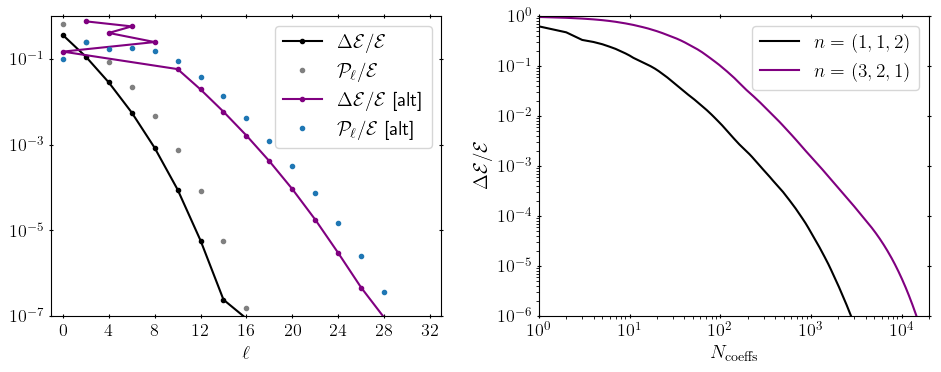

In [12]:
unisize = 3
fig = plt.figure(figsize=[1.3*unisize,unisize])
labels = 13
largelabels = 14
ax = fig.add_axes([0,0,1,1], xscale='linear', yscale='log')

ax.plot([l for l in powerL.keys()], 1-np.array(conv_l), 
        marker='.', color='black', label=r'$\Delta\mathcal{E} / \mathcal{E}$')
ax.plot(p_l[:,0],p_l[:,1], color='gray',
        marker='.', linestyle='None', label=r'$\mathcal{P}_\ell / \mathcal{E}$')

ax.plot([l for l in powerL_alt.keys()], 1-np.array(conv_l_alt), 
        marker='.', color='purple', label=r'$\Delta\mathcal{E} / \mathcal{E}$ [alt]')
ax.plot(p_l_alt[:,0],p_l_alt[:,1], 
        marker='.', linestyle='None', label=r'$\mathcal{P}_\ell / \mathcal{E}$ [alt]')

ax.set_xlim([-1, 33])
ax.set_xticks([4*j for j in range(9)])
ax.set_ylim([1e-7, 1])
ax.set_xlabel(r'$\ell$', fontsize=largelabels, usetex=True)
# ax.set_ylabel(r'$\Delta\mathcal{E} / \mathcal{E}$', fontsize=largelabels, usetex=True)
ax.tick_params(axis='both', labelsize=labels, direction='inout',
               right=True, top=True, labelleft=True, labelright=False,
               labelbottom=True, labeltop=False)
ax.legend(loc='upper right', fontsize=largelabels)

ax2 = fig.add_axes([1.25,0,1,1], xscale='log', yscale='log')
ax2.plot([i+1 for i in range(len(conv))], 1-np.array(conv), 
         color='black', label=r'$n = (1, 1, 2)$')
ax2.plot([i+1 for i in range(len(conv_alt))], 1-np.array(conv_alt), 
         color='purple', 
         label=r'$n = (3, 2, 1)$')
ax2.set_xlim([1, 2e4])
ax2.set_ylim([1e-6, 1])
ax2.set_xlabel(r'$N_{\rm coeffs}$', fontsize=largelabels, usetex=True)
ax2.set_ylabel(r'$\Delta\mathcal{E} / \mathcal{E}$', fontsize=largelabels, usetex=True)
ax2.tick_params(axis='both', labelsize=labels, direction='inout',
                right=True, top=True, labelleft=True, labelright=False,
                labelbottom=True, labeltop=False)
ax2.legend(loc='upper right', fontsize=largelabels)

fig.show()

In [13]:
powerLM = fs2.getLMpower()
sortlm = sorted(powerLM.items(), key=lambda z: z[1], reverse=True)

powerLM = {}
sum_lm = 0.
conv_lm = []
for entry in sortlm:
    key, power = entry
    powerLM[key] = power
    power /= totalEnergy_fs2
    sum_lm += power
    conv_lm += [sum_lm]
    if power > 1e-9:
        print('{}  \t{:.6G}  \t{}'.format(key, power, sum_lm))

p_nlm = fs2.getNLMpower(lMax=12)
p_lm_n = {}
sump_lm_n = {}
n_coeffs_n = 2**10
for lmP in sortlm[0:9]:
    (lm,P) = lmP
    plm = P
    p_lm_n[lm] = [p_nlm[(n, lm[0], lm[1])]/plm for n in range(n_coeffs_n)]
    sump = 0.0
    sump_lm_n[lm] = np.zeros(n_coeffs_n)
    for n in range(n_coeffs_n):
        sump += p_lm_n[lm][n]
        sump_lm_n[lm][n] = sump


(0, 0)  	0.642452  	0.642452056196576
(2, 0)  	0.197568  	0.8400197397592503
(4, 0)  	0.0689423  	0.908962056732362
(2, 2)  	0.0478349  	0.9567969749713998
(4, 2)  	0.0130654  	0.9698624097626342
(6, 0)  	0.0117365  	0.9815988952651789
(6, 2)  	0.0102456  	0.9918444598461799
(8, 2)  	0.00261652  	0.994460976380395
(4, 4)  	0.00206854  	0.9965295157501085
(8, 0)  	0.00159231  	0.9981218296017529
(8, 4)  	0.000518814  	0.9986406433052375
(6, 4)  	0.000460075  	0.9991007186823437
(10, 2)  	0.000373856  	0.9994745749257985
(10, 0)  	0.000189961  	0.999664536024115
(10, 4)  	0.000167771  	0.9998323067731383
(6, 6)  	5.4091E-05  	0.9998863977392496
(12, 2)  	3.27853E-05  	0.9999191830463197
(12, 4)  	2.70436E-05  	0.9999462266707836
(12, 0)  	1.76782E-05  	0.9999639048806029
(10, 6)  	1.43586E-05  	0.9999782634546904
(8, 6)  	1.02815E-05  	0.9999885449499365
(12, 6)  	5.37628E-06  	0.9999939212301759
(14, 4)  	2.07025E-06  	0.9999959914810971
(14, 2)  	1.50876E-06  	0.9999975002408065
(14, 6

/var/folders/9f/0fs4y5917_q6nlh99_p3shbw0000gn/T/ipykernel_82531/550360769.py:85: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


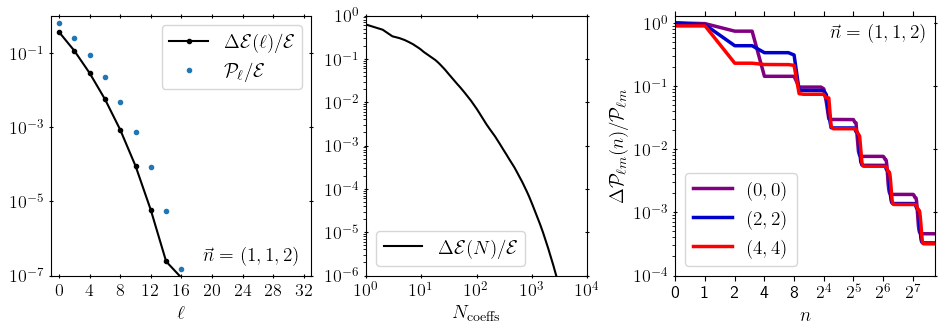

In [14]:
unisize = 2.6
fig = plt.figure(figsize=[1.*unisize,unisize])
labels = 13
fonts = 14

largelabels = 14
nsize = 2**10
ax = fig.add_axes([0,0,1,1], xscale='linear', yscale='log')
ax.plot([l for l in powerL.keys()], 1-np.array(conv_l), 
        marker='.', color='black', label=r'$\Delta\mathcal{E}(\ell) / \mathcal{E}$')
ax.plot(p_l[:,0],p_l[:,1], 
        marker='.', linestyle='None', label=r'$\mathcal{P}_\ell / \mathcal{E}$')
ax.set_xlim([-1, 33])
ax.set_xticks([4*j for j in range(9)])
ax.set_ylim([1e-7, 1])
ax.set_xlabel(r'$\ell$', fontsize=largelabels, usetex=True)
ax.tick_params(axis='both', labelsize=labels, direction='inout',
               right=True, top=True, labelleft=True, labelright=False,
               labelbottom=True, labeltop=False)
ax.legend(loc='upper right', fontsize=largelabels)
ax.text(0.96, 0.04, r'$\vec{n}=(1,1,2)$', horizontalalignment='right',
         verticalalignment='bottom', fontsize=fonts, 
         color='black', backgroundcolor='white',
         transform=ax.transAxes, usetex=True)

ax2 = fig.add_axes([1.21,0,0.85,1], xscale='log', yscale='log')
ax2.plot([i+1 for i in range(len(conv))], 1-np.array(conv), 
         color='black', label=r'$\Delta\mathcal{E}(N) / \mathcal{E}$')
ax2.set_xlim([1, 1e4])
ax2.set_ylim([1e-6, 1])
ax2.set_xticks([10**j for j in range(5)])
ax2.set_xlabel(r'$N_{\rm coeffs}$', fontsize=largelabels, usetex=True)
ax2.tick_params(axis='both', labelsize=labels, direction='inout',
                right=True, top=True, labelleft=True, labelright=False,
                labelbottom=True, labeltop=False)
ax2.legend(loc='lower left', fontsize=largelabels)


lm_B = (2, 2)
lm_A = (0, 0)
lm_C = (4, 4)

ax3 = fig.add_axes([2.4,0,1,1], xscale='log', yscale='log')
nlist0 = [0.5]+[n for n in range(1,nsize)]
# for lbl in p_lm_n.keys():
#     if lbl != lm_A and lbl != lm_B and lbl != lm_C:
#         ax3.plot(nlist0, 1-sump_lm_n[lbl], color='gray')
ax3.plot(nlist0, 1-sump_lm_n[lm_A], linewidth=2.5,
         color='purple', label=r'${}$'.format(lm_A))
ax3.plot(nlist0, 1-sump_lm_n[lm_B], linewidth=2.5,
         color='mediumblue', label=r'${}$'.format(lm_B))
ax3.plot([n for n in range(nsize)], 1-sump_lm_n[lm_C], 
         color='red', label=r'${}$'.format(lm_C), 
         linewidth=2.5)
# ax3.plot([n for n in range(nsize)], 1-sump_lm_n[(4,4)], 
#          color='darkorange', label=r'$(4,4)$')

# ax3.set_xlim([0, 96])
power2_plot = 8
ax3.set_xlim([1, 0.85*2**power2_plot])
ax3.set_ylim([1e-4, 1.3])
ax3.set_xticks([2**j for j in range(-1,power2_plot)], 
               labels=(["0"]+[str(int(2**j)) for j in range(4)] 
                       + [r"$2^{}$".format(j) for j in range(4, power2_plot)])
              )
ax3.set_xlabel(r'$n$', fontsize=largelabels, usetex=True)
ax3.set_ylabel(r'$\Delta \mathcal{P}_{\ell m}(n) / \mathcal{P}_{\ell m}$', 
               fontsize=largelabels, usetex=True)
ax3.tick_params(axis='x', labelsize=labels, direction='out',
                right=True, top=True, labelleft=True, labelright=False,
                labelbottom=True, labeltop=False)
ax3.tick_params(axis='x', which='minor', bottom=False)
ax3.tick_params(axis='y', labelsize=labels, direction='inout',
                right=True, top=True, labelleft=True, labelright=False,
                labelbottom=True, labeltop=False)
ax3.legend(loc='lower left', fontsize=largelabels)
ax3.text(0.97, 0.97, r'$\vec{n}=(1,1,2)$', horizontalalignment='right',
         verticalalignment='top', fontsize=fonts, 
         color='black', backgroundcolor='white',
         transform=ax3.transAxes, usetex=True)

# plt.savefig('out/fs2_convergence.pdf', format="pdf", bbox_inches='tight')


fig.show()

In [15]:
powerLM = fs2_alt.getLMpower()
sortlm = sorted(powerLM.items(), key=lambda z: z[1], reverse=True)

powerLM = {}
sum_lm = 0.
conv_lm = []
for entry in sortlm:
    key, power = entry
    powerLM[key] = power
    power /= totalEnergy_fs2_alt
    sum_lm += power
    conv_lm += [sum_lm]
    if power > 1e-9:
        print('{}  \t{:.6G}  \t{}'.format(key, power, sum_lm))

p_nlm = fs2_alt.getNLMpower(lMax=12)
p_lm_n = {}
sump_lm_n = {}
n_coeffs_n = 2**10
for lmP in sortlm[0:9]:
    (lm,P) = lmP
    plm = P
    p_lm_n[lm] = [p_nlm[(n, lm[0], lm[1])]/plm for n in range(n_coeffs_n)]
    sump = 0.0
    sump_lm_n[lm] = np.zeros(n_coeffs_n)
    for n in range(n_coeffs_n):
        sump += p_lm_n[lm][n]
        sump_lm_n[lm][n] = sump


(2, 2)  	0.14619  	0.14619010092520676
(2, 0)  	0.105886  	0.25207592632483966
(0, 0)  	0.0988134  	0.3508893327678912
(8, 8)  	0.0836067  	0.4344960508108923
(6, 6)  	0.0804967  	0.5149927164175832
(4, 2)  	0.0802561  	0.5952488240178925
(4, 0)  	0.0756302  	0.6708790554794596
(6, 2)  	0.0473535  	0.718232563561908
(6, 0)  	0.0449151  	0.7631477061747234
(10, 10)  	0.0377073  	0.800855006275602
(8, 2)  	0.0249244  	0.8257793904177744
(8, 0)  	0.0228075  	0.8485868849882929
(10, 8)  	0.0222075  	0.8707943554806074
(8, 6)  	0.0217987  	0.8925930363379162
(4, 4)  	0.0136125  	0.9062054962223736
(10, 2)  	0.0115554  	0.9177608729011038
(10, 0)  	0.0100804  	0.9278412695895688
(12, 10)  	0.00977606  	0.9376173344455978
(12, 12)  	0.00972038  	0.947337718307617
(12, 8)  	0.00748626  	0.9548239827567584
(10, 6)  	0.00712279  	0.9619467692207901
(12, 2)  	0.00472579  	0.966672562606823
(6, 4)  	0.00458288  	0.9712554440037052
(12, 0)  	0.0039226  	0.9751780415750684
(14, 10)  	0.00329214  	0.

/var/folders/9f/0fs4y5917_q6nlh99_p3shbw0000gn/T/ipykernel_82531/3071957545.py:83: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


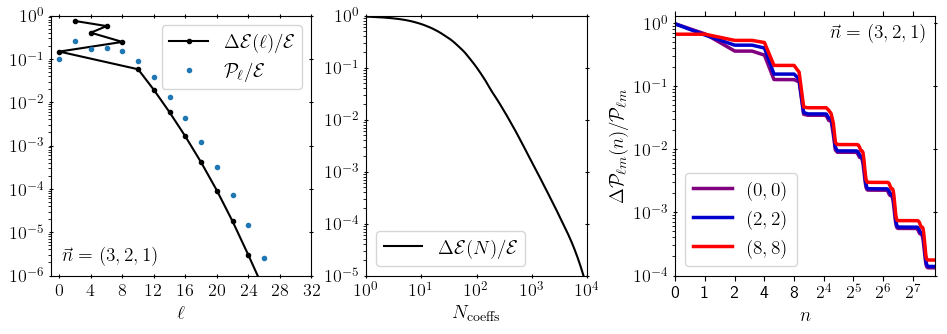

In [16]:
unisize = 2.6
fig = plt.figure(figsize=[1.*unisize,unisize])
labels = 13
largelabels = 14
nsize = 2**10
ax = fig.add_axes([0,0,1,1], xscale='linear', yscale='log')
ax.plot([l for l in powerL_alt.keys()], 1-np.array(conv_l_alt), 
        marker='.', color='black', label=r'$\Delta\mathcal{E}(\ell) / \mathcal{E}$')
ax.plot(p_l_alt[:,0],p_l_alt[:,1], 
        marker='.', linestyle='None', label=r'$\mathcal{P}_\ell / \mathcal{E}$')
ax.set_xlim([-1, 29])
ax.set_xticks([4*j for j in range(9)])
ax.set_ylim([1e-6, 1])
ax.set_xlabel(r'$\ell$', fontsize=largelabels, usetex=True)
ax.tick_params(axis='both', labelsize=labels, direction='inout',
               right=True, top=True, labelleft=True, labelright=False,
               labelbottom=True, labeltop=False)
ax.legend(loc='upper right', fontsize=largelabels)
ax.text(0.04, 0.04, r'$\vec{n}=(3,2,1)$', horizontalalignment='left',
         verticalalignment='bottom', fontsize=largelabels, 
         color='black', backgroundcolor='white',
         transform=ax.transAxes, usetex=True)

ax2 = fig.add_axes([1.21,0,0.85,1], xscale='log', yscale='log')
ax2.plot([i+1 for i in range(len(conv_alt))], 1-np.array(conv_alt), 
         color='black', label=r'$\Delta\mathcal{E}(N) / \mathcal{E}$')
ax2.set_xlim([1, 1e4])
ax2.set_ylim([1e-5, 1])
ax2.set_xticks([10**j for j in range(5)])
ax2.set_xlabel(r'$N_{\rm coeffs}$', fontsize=largelabels, usetex=True)
ax2.tick_params(axis='both', labelsize=labels, direction='inout',
                right=True, top=True, labelleft=True, labelright=False,
                labelbottom=True, labeltop=False)
ax2.legend(loc='lower left', fontsize=largelabels)


lm_B = (2, 2)
lm_A = (0, 0)
lm_C = (8, 8)

ax3 = fig.add_axes([2.4,0,1,1], xscale='log', yscale='log')
nlist0 = [0.5]+[n for n in range(1,nsize)]
# for lbl in p_lm_n.keys():
#     if lbl != lm_A and lbl != lm_B and lbl != lm_C:
#         ax3.plot(nlist0, 1-sump_lm_n[lbl], color='gray')
ax3.plot(nlist0, 1-sump_lm_n[lm_A], linewidth=2.5,
         color='purple', label=r'${}$'.format(lm_A))
ax3.plot(nlist0, 1-sump_lm_n[lm_B], linewidth=2.5,
         color='mediumblue', label=r'${}$'.format(lm_B))
ax3.plot([n for n in range(nsize)], 1-sump_lm_n[lm_C], 
         color='red', label=r'${}$'.format(lm_C), 
         linewidth=2.5)
# ax3.plot([n for n in range(nsize)], 1-sump_lm_n[(4,4)], 
#          color='darkorange', label=r'$(4,4)$')

# ax3.set_xlim([0, 96])
power2_plot = 8
ax3.set_xlim([1, 0.85*2**power2_plot])
ax3.set_ylim([1e-4, 1.3])
ax3.set_xticks([2**j for j in range(-1,power2_plot)], 
               labels=(["0"]+[str(int(2**j)) for j in range(4)] 
                       + [r"$2^{}$".format(j) for j in range(4, power2_plot)])
              )
ax3.set_xlabel(r'$n$', fontsize=largelabels, usetex=True)
ax3.set_ylabel(r'$\Delta \mathcal{P}_{\ell m}(n) / \mathcal{P}_{\ell m}$', 
               fontsize=largelabels, usetex=True)
ax3.tick_params(axis='x', labelsize=labels, direction='out',
                right=True, top=True, labelleft=True, labelright=False,
                labelbottom=True, labeltop=False)
ax3.tick_params(axis='x', which='minor', bottom=False)
ax3.tick_params(axis='y', labelsize=labels, direction='inout',
                right=True, top=True, labelleft=True, labelright=False,
                labelbottom=True, labeltop=False)
ax3.legend(loc='lower left', fontsize=largelabels)
ax3.text(0.97, 0.97, r'$\vec{n}=(3,2,1)$', horizontalalignment='right',
         verticalalignment='top', fontsize=largelabels, 
         color='black', backgroundcolor='white',
         transform=ax3.transAxes, usetex=True)

plt.savefig('out/fs2_convergence.png', format="png", dpi=300, bbox_inches='tight')


fig.show()

# Demonstration: Filtered versions of gX and fs2

Most of the $> 10^5$ coefficients included in the CSV files are irrelevantly small, and can be discarded. This section introduces various precision goals on the $\langle f | n \ell m \rangle^2$ norm, $\mathcal E$, keeping only the coefficients necessary to reconstruct $\mathcal E$ to the desired level of precision (10%, 3%, ..., 0.01%). 

This section calculates the partial rate matrix in three examples. Example 1 uses the sparse sum method, while Examples 2 and 3 use the vector sum. Example 2 calculates the matrix $\mathcal I^{(\ell)}$ with modified values of $n_{max}$ and $\ell_{max}$, while Example 3 uses the complete set of coefficients from the CSV file. To run the rate calculation in the following section, at least one of these Examples should be evaluated. Note that Example 3 takes substantially longer to run than either of the other two examples. 

In [17]:
g_norm = gX.f2nlm_norm()
f_norm = fs2.f2nlm_norm()
falt_norm = fs2_alt.f2nlm_norm()


In [18]:
# Sorting the coefficients according to size:
sume = 0.
# conv = []
gNLM_n = {}
nlist = [10, 30, 100, 300, 1000, 3000, 10000]
for n in nlist:
    gNLM_n[n] = []
for key,value in gX.getNLMpower().items():
    power = value/g_norm
    sume += power
#     conv += [sume.mean]
    if sume < 0.9:
        gNLM_n[10] += [key]
    if sume < 0.97:
        gNLM_n[30] += [key]
    if sume < 0.99:
        gNLM_n[100] += [key]
    if sume < 0.997:
        gNLM_n[300] += [key]
    if sume < 0.999:
        gNLM_n[1000] += [key]
    if sume < 0.9997:
        gNLM_n[3000] += [key]
    if sume < 0.9999:
        gNLM_n[10000] += [key]
    if sume > 0.9999:
        break
    
[len(gNLM_n[n]) for n in nlist]

[1430, 3062, 5229, 8483, 12294, 17211, 22153]

In [19]:
# Sorting the coefficients according to size:
sume = 0.
# conv = []
fNLM_n = {}
for n in nlist:
    fNLM_n[n] = []
for key,value in fs2.getNLMpower().items():
    power = value/f_norm
    sume += power
#     conv += [sume.mean]
    if sume < 0.9:
        fNLM_n[10] += [key]
    if sume < 0.97:
        fNLM_n[30] += [key]
    if sume < 0.99:
        fNLM_n[100] += [key]
    if sume < 0.997:
        fNLM_n[300] += [key]
    if sume < 0.999:
        fNLM_n[1000] += [key]
    if sume < 0.9997:
        fNLM_n[3000] += [key]
    if sume < 0.9999:
        fNLM_n[10000] += [key]
    if sume > 0.9999:
        break
    
[len(fNLM_n[n]) for n in nlist]

[16, 40, 82, 153, 274, 493, 771]

In [20]:
# Sorting the coefficients according to size:
sume = 0.
# conv = []
fNLMalt_n = {}
for n in nlist:
    fNLMalt_n[n] = []
for key,value in fs2_alt.getNLMpower().items():
    power = value/falt_norm
    sume += power
#     conv += [sume.mean]
    if sume < 0.9:
        fNLMalt_n[10] += [key]
    if sume < 0.97:
        fNLMalt_n[30] += [key]
    if sume < 0.99:
        fNLMalt_n[100] += [key]
    if sume < 0.997:
        fNLMalt_n[300] += [key]
    if sume < 0.999:
        fNLMalt_n[1000] += [key]
    if sume < 0.9997:
        fNLMalt_n[3000] += [key]
    if sume < 0.9999:
        fNLMalt_n[10000] += [key]
    if sume > 0.9999:
        break
    
[len(fNLMalt_n[n]) for n in nlist]

[100, 206, 387, 718, 1235, 2201, 3673]

In [21]:
"""Import selected coefficients by hand:"""
gX_n = {}
fs2_n = {}
fs2alt_n = {}
ellMax_n = {}
ellMaxalt_n = {}
for n in nlist:
    gX_n[n] = vsdm.Fnlm(Vdict, f_type='gX', use_gvar=False)
    gX_n[n].importFromProjF(gX, gNLM_n[n])
    fs2_n[n] = vsdm.Fnlm(Qdict, f_type='fs2', use_gvar=False)
    fs2_n[n].importFromProjF(fs2, fNLM_n[n])
    fs2alt_n[n] = vsdm.Fnlm(Qdict, f_type='fs2', use_gvar=False)
    fs2alt_n[n].importFromProjF(fs2_alt, fNLMalt_n[n])
    ellMax_n[n] = np.min([gX_n[n].ellMax, fs2_n[n].ellMax])
    ellMaxalt_n[n] = np.min([gX_n[n].ellMax, fs2alt_n[n].ellMax])

print('ell max:', [ellMax_n[n] for n in nlist])
print('nv max:', [gX_n[n].nMax for n in nlist])
print('nq max:', [fs2_n[n].nMax for n in nlist])
print('ell max [alt]:', [ellMaxalt_n[n] for n in nlist])
print('nq max [alt]:', [fs2alt_n[n].nMax for n in nlist])


ell max: [4, 8, 10, 10, 12, 12, 14]
nv max: [46, 92, 185, 186, 187, 188, 189]
nq max: [35, 36, 73, 146, 291, 579, 594]
ell max [alt]: [14, 16, 18, 20, 24, 26, 26]
nq max [alt]: [20, 21, 44, 87, 174, 346, 679]


## Example 1: sparse sum method for partial rate matrix K

Rather than evaluating the full matrix McalI, this method evaluates the partial rate matrix K by computing only the terms that show up in the sum: 
$$\mathcal K_{mm'}^{(\ell)} = \sum_{n, n'} v_\text{max}^3 \langle g_\chi | n \ell m\rangle \mathcal I^{(\ell)}_{n n'} \langle n' \ell m' | f_s^2 \rangle. $$
This may be more efficient if the number of nonzero coefficients is small, and the number of different $g_\chi$ and $f_s^2$ models is not large. Usually, however, it is faster to evaluate $K^{(\ell)}$ by first calculating the matrix $\mathcal I^{(\ell)}$, especially if there are multiple versions of $g_\chi(\vec v)$ or $f_s^2(\vec q)$.

This example, and Example 2, compare the evaluation times for $K$ using two different methods. Because the wavelet-harmonic expansion converges especially quickly for the $n = (1, 1, 2)$ form factor, the 'sparse' method is rather fast. 

In [22]:
n = 300 # for precision goal of 0.3% 

gX_eg = gX_n[n]
fs2_eg = fs2_n[n]

ellMax = ellMax_n[n]
nvMax = gX_eg.nMax
nqMax = fs2_eg.nMax

# ls10 = [1, 1.5, 2, 3, 4, 5, 6, 7, 8, 9]
ls10 = [1]
p10 = [1, 10, 100]
mXlist = np.array([p*m for p in p10 for m in ls10])

mI = {}
modelsDM = []
# t0 = time.time()
for fn in [0,2]:
    for mX in mXlist:
        modelsDM += [(mX, fn)]
        dmModel = dict(mX=mX*MeV, fdm_n=fn, mSM=mElec, DeltaE=fs2_model4.DeltaE)
        mI[(mX, fn)] = vsdm.McalI(Vdict, Qdict, dmModel, 
                                  mI_shape=(ellMax+1, nvMax+1,nqMax+1), 
                                  use_gvar=False, do_mcalI=False)


t0 = time.time()
rates = {}
for modelDM in modelsDM:
    rates[modelDM] = vsdm.RateCalc(gX_eg, fs2_eg, mI[modelDM], lmod=2,
                                   use_gvar=False, sparse=True)
    print(modelDM, ": ", rates[modelDM].t_eval)
tEvalR = time.time() - t0
print("average t_eval:", tEvalR/len(modelsDM))

"""Now repeat for the 'alt' model:"""
fs2_eg = fs2alt_n[n]
ellMax = ellMaxalt_n[n]
nqMax = fs2_eg.nMax

t0 = time.time()
ratesalt = {}
for modelDM in modelsDM:
    mX, fn = modelDM
    dmModel = dict(mX=mX*MeV, fdm_n=fn, mSM=mElec, DeltaE=fs2_model4_alt.DeltaE)
    mI[(mX, fn)] = vsdm.McalI(Vdict, Qdict, dmModel, 
                              mI_shape=(ellMax+1, nvMax+1,nqMax+1), 
                              use_gvar=False, do_mcalI=False)
    ratesalt[modelDM] = vsdm.RateCalc(gX_eg, fs2_eg, mI[modelDM], lmod=2,
                                      use_gvar=False, sparse=True)
    print(modelDM, ": ", ratesalt[modelDM].t_eval)
tEvalR = time.time() - t0
print("average t_eval:", tEvalR/len(modelsDM))


(1, 0) :  0.6021687984466553
(10, 0) :  6.284766912460327
(100, 0) :  7.338901996612549
(1, 2) :  0.612180233001709
(10, 2) :  6.386916875839233
(100, 2) :  7.433655023574829
average t_eval: 4.776644190152486
(1, 0) :  3.8814291954040527
(10, 0) :  86.45081496238708
(100, 0) :  87.74761319160461
(1, 2) :  4.027225017547607
(10, 2) :  85.54861688613892
(100, 2) :  86.56925082206726
average t_eval: 59.03807417551676


Below, the first few $K(\ell, m, m')$ coefficients are shown (for even $\ell$ only). The symmetries of $f_s^2(\vec q)$ cause $K_{m m'}$ to vanish for negative $m'$, and for odd $m'$. For the four-gaussian $g_\chi(\vec v)$ model, there are no restrictions on $m$; however, the azimuthally symmetric standard halo model would only have support at $m=0$. 

In [23]:
print(rates[(100, 0)].vecK[0:20])
print(ratesalt[(100, 0)].vecK[0:20])


[0.04085225 0.         0.         0.00146256 0.         0.00210917
 0.         0.         0.00139521 0.         0.00257203 0.
 0.         0.00440198 0.         0.00152057 0.         0.
 0.00071677 0.        ]
[ 0.03413032  0.          0.          0.00103614  0.         -0.00152835
  0.          0.          0.00103333  0.         -0.0015857   0.
  0.          0.00107499  0.         -0.00144284  0.          0.
  0.0057647   0.        ]


In [24]:
# To compare these results against Examples 2 and 3, save 'rates' and 'ratesalt' with unique names:
rates_v1 = {key:val for key,val in rates.items()}
ratesalt_v1 = {key:val for key,val in ratesalt.items()}

## Example 2: direct evaluation of mcalI and mcalK

In most cases, it is faster to calculate $K^{(\ell)}$ using the full $I^{(\ell)}$ matrix for each DM model. This way, each coefficient of $K^{(\ell)}_{mm'}$ is the product of a vector, a matrix, and another vector. This is typically much faster than the sparse sum, which uses a 'for' loop.

In [25]:
n = 300  # for precision goal of 0.3% 
# ellMax = 24
ellMax = ellMax_n[n]
nvMax = gX_n[n].nMax
nqMax = fs2_n[n].nMax

# ls10 = [1, 1.5, 2, 3, 4, 5, 6, 7, 8, 9]
ls10 = [1]
p10 = [1, 10, 100]
mXlist = np.array([p*m for p in p10 for m in ls10])

"""Check the evaluation time for mcalI:"""
mI = {}
modelsDM = []
t0 = time.time()
for fn in [0,2]:
    for mX in mXlist:
        modelsDM += [(mX, fn)]
        dmModel = dict(mX=mX*MeV, fdm_n=fn, mSM=mElec, DeltaE=fs2_model4.DeltaE)
        mI[(mX, fn)] = vsdm.McalI(Vdict, Qdict, dmModel, 
                                  mI_shape=(ellMax+1, nvMax+1,nqMax+1), center_Z2=True, 
                                  use_gvar=False, do_mcalI=True)
        print('\t', (mX, fn), ": ", mI[(mX, fn)].t_eval)
tEvalI = time.time() - t0
print('tI avg:', tEvalI/len(modelsDM))


"""Check again, this time for the 'alt' form factor (with larger nMax, ellMax):"""

ellMax = ellMaxalt_n[n]
nvMax = gX_n[n].nMax
nqMax = fs2alt_n[n].nMax

mIalt = {}
modelsDM = []
t0 = time.time()
for fn in [0,2]:
    for mX in mXlist:
        modelsDM += [(mX, fn)]
        dmModel = dict(mX=mX*MeV, fdm_n=fn, mSM=mElec, DeltaE=fs2_model4_alt.DeltaE)
        mIalt[(mX, fn)] = vsdm.McalI(Vdict, Qdict, dmModel, 
                                     mI_shape=(ellMax+1, nvMax+1,nqMax+1), center_Z2=True, 
                                     use_gvar=False, do_mcalI=True)
        print('\t', (mX, fn), ": ", mIalt[(mX, fn)].t_eval)
tEvalIalt = time.time() - t0
print('tI avg [alt]:', tEvalIalt/len(modelsDM))



	 (1, 0) :  3.464125871658325
	 (10, 0) :  22.135358095169067
	 (100, 0) :  34.76938986778259
	 (1, 2) :  3.451082944869995
	 (10, 2) :  22.401612997055054
	 (100, 2) :  34.779765129089355
tI avg: 20.167039314905804
	 (1, 0) :  4.552057981491089
	 (10, 0) :  44.797104835510254
	 (100, 0) :  67.3056058883667
	 (1, 2) :  4.551271915435791
	 (10, 2) :  45.17945098876953
	 (100, 2) :  67.57869791984558
tI avg [alt]: 38.994186321894325


In [26]:
"""
    Next, calculate K from McalI. For a center-symmetric form factor, fs2.center_Z2=True, 
    all coefficients of K^(ell) for odd 'ell' vanish. Setting 'lmod=2' in RateCalc allows it 
    to skip all odd 'ell' automatically. 
"""
# ellMax = ellMax_n[n]
gX_eg = gX_n[n]
fs2_eg = fs2_n[n]
fs2alt_eg = fs2alt_n[n]


t0 = time.time()
rates = {}
mK = {}
for modelDM in mI.keys():
    rateIndex = modelDM
    # mK[modelDM] = vsdm._mcalK(gX_eg, fs2_eg, mI[modelDM], ellMax=ellMax,
    #                           sparse=True, use_gvar=False)
    rates[rateIndex] = vsdm.RateCalc(gX_eg, fs2_eg, mI[modelDM], lmod=2,
                                     use_gvar=False, sparse=False)
    print('\t', modelDM, ": ", rates[rateIndex].t_eval)
tEvalR = time.time() - t0
print('t_avg K:', tEvalR/len(modelsDM))

t0 = time.time()
ratesalt = {}
mKalt = {}
for modelDM in mIalt.keys():
    rateIndex = modelDM
    # mKalt[modelDM] = vsdm._mcalK(gX_eg, fs2alt_eg, mI[modelDM], ellMax=ellMax,
    #                           sparse=True, use_gvar=False)
    ratesalt[rateIndex] = vsdm.RateCalc(gX_eg, fs2alt_eg, mIalt[modelDM], lmod=2,
                                     use_gvar=False, sparse=False)
    print('\t', modelDM, ": ", ratesalt[rateIndex].t_eval)
tEvalRalt = time.time() - t0
print('t_avg K [alt]:', tEvalRalt/len(modelsDM))


	 (1, 0) :  0.13414502143859863
	 (10, 0) :  0.13868284225463867
	 (100, 0) :  0.1367800235748291
	 (1, 2) :  0.1438908576965332
	 (10, 2) :  0.1380620002746582
	 (100, 2) :  0.142564058303833
t_avg K: 0.139277974764506
	 (1, 0) :  0.1595919132232666
	 (10, 0) :  0.1595149040222168
	 (100, 0) :  0.1573939323425293
	 (1, 2) :  0.1548900604248047
	 (10, 2) :  0.15364980697631836
	 (100, 2) :  0.15435171127319336
t_avg K [alt]: 0.15675564606984457


After $I^{(\ell)}$ has been calculated, getting $K^{(\ell)}$ is very fast. This step typically takes less than a second, for e.g. the $\Delta \mathcal E < 0.1\% \mathcal E$ level of precision.

Below, the first few $K(\ell, m, m')$ coefficients are shown (for even $\ell$ only). The symmetries of $f_s^2(\vec q)$ cause $K_{m m'}$ to vanish for negative $m'$, and for odd $m'$. For the four-gaussian $g_\chi(\vec v)$ model, there are no restrictions on $m$; however, the azimuthally symmetric standard halo model would only have support at $m=0$. 

The values here should match those from Example 1: both of these calculations used the same list of <gX|nlm> and <fs2|nlm> coefficients. To test the accuracy of the $K^{(\ell)}_{mm'}$, run Example 3 and compare. 

In [27]:
print(rates[(100, 0)].vecK[0:20])
print(ratesalt[(100, 0)].vecK[0:20])

[0.04085225 0.         0.         0.00146256 0.         0.00210917
 0.         0.         0.00139521 0.         0.00257203 0.
 0.         0.00440198 0.         0.00152057 0.         0.
 0.00071677 0.        ]
[ 0.03413032  0.          0.          0.00103614  0.         -0.00152835
  0.          0.          0.00103333  0.         -0.0015857   0.
  0.          0.00107499  0.         -0.00144284  0.          0.
  0.0057647   0.        ]


In [28]:
# To compare these results against Examples 1 and 3, save 'rates' and 'ratesalt' with unique names:
rates_v2 = {key:val for key,val in rates.items()}
ratesalt_v2 = {key:val for key,val in ratesalt.items()}

## Example 3: partial rate matrix at maximum precision 

This example calculates $K^{(\ell)}_{mm'}$ directly from the CSV files, without discarding any of the coefficients. The method is the same as in Example 2, but now $n_{max}$ and $\ell_{max}$ are larger, so the $\mathcal I^{(\ell)}$ calculation is slower by an order of magnitude or so. Evaluating $K^{(\ell)}$ is also slower, as the vectors $\langle f_{\ell m} | n \rangle$ are larger, and there are more $(\ell, m, m')$ coefficients (proportional to $\ell_{max}^3$). 

**Caution:** it can take around an hour to evaluate McalI for each DM model in this example.

### A practical note: 
All of the experimentally relevant data is contained in the partial rate matrix $K^{(\ell)}_{m m'}$. That is, $K$ is what determines the scattering rate $R(\mathcal R)$ as a function of orientation $\mathcal R$. Compared to $\mathcal I^{(\ell)}$, a 3d array of size $\sim n_{max} n'_{max} \ell_{max}$, the object $K$ is also fairly small, with $\mathcal O(\ell_{max}^3)$ coefficients. So, for an analysis with only a few $g_\chi$ and $f_s^2$ models, it would be most economical to save the values of RateCalc.vecK for each DM model. 

If the number of $g_\chi$ and/or $f_s^2$ models is large, however, it may be better to save the values of 3d arrays $\mathcal I^{(\ell)}_{nn'}$. There is a built-in method to save this data to an HDF5 file: McalI.writeMcalI(), which keeps track of the 'modelDMSM' data to save multiple versions of McalI to the same HDF5 file. 

In [144]:
print(gX.nMax, fs2.nMax, fs2_alt.nMax)
print(gX.ellMax, fs2.ellMax, fs2_alt.ellMax)

255 1023 1023
36 30 36


In [143]:
print(len(gX.f_nlm.keys()), len(fs2.f_nlm.keys()), len(fs2_alt.f_nlm.keys()))

350464 114688 194560


In [141]:
# n = 10000 
# ellMax = 24
ellMax = np.min([gX.ellMax, fs2.ellMax])
nvMax = gX.nMax
nqMax = fs2.nMax

# ls10 = [1, 1.5, 2, 3, 4, 5, 6, 7, 8, 9]
ls10 = [1]
p10 = [1, 100]
mXlist = np.array([p*m for p in p10 for m in ls10])
# mXlist = mXlist[0:25]

"""Check the evaluation time for mcalI:"""
mI = {}
modelsDM = []
t0 = time.time()
# for fn in [0,2]:
for fn in [0]:
    for mX in mXlist:
        modelsDM += [(mX, fn)]
        dmModel = dict(mX=mX*MeV, fdm_n=fn, mSM=mElec, DeltaE=fs2_model4.DeltaE)
        mI[(mX, fn)] = vsdm.McalI(Vdict, Qdict, dmModel, 
                                  mI_shape=(ellMax+1, nvMax+1,nqMax+1), center_Z2=True, 
                                  use_gvar=False, do_mcalI=True)
        print('\t', (mX, fn), ": ", mI[(mX, fn)].t_eval)
tEvalI = time.time() - t0
print('tI avg:', tEvalI/len(modelsDM))

ellMax = np.min([gX.ellMax, fs2_alt.ellMax])
# nvMax = gX.nMax
nqMax = fs2_alt.nMax

mIalt = {}
modelsDM = []
t0 = time.time()
# for fn in [0,2]:
for fn in [0]:
    for mX in mXlist:
        modelsDM += [(mX, fn)]
        dmModel = dict(mX=mX*MeV, fdm_n=fn, mSM=mElec, DeltaE=fs2_model4.DeltaE)
        mIalt[(mX, fn)] = vsdm.McalI(Vdict, Qdict, dmModel, 
                                     mI_shape=(ellMax+1, nvMax+1,nqMax+1), center_Z2=True, 
                                     use_gvar=False, do_mcalI=True)
        print('\t', (mX, fn), ": ", mIalt[(mX, fn)].t_eval)
tEvalIalt = time.time() - t0
print('tI avg [alt]:', tEvalIalt/len(modelsDM))

"""Check the evaluation time for mcalK:"""

t0 = time.time()
rates = {}
mK = {}
for modelDM in mI.keys():
    rateIndex = modelDM
    # mK[modelDM] = vsdm._mcalK(gX_eg, fs2_eg, mI[modelDM], ellMax=ellMax,
    #                           sparse=True, use_gvar=False)
    rates[rateIndex] = vsdm.RateCalc(gX, fs2, mI[modelDM], 
                                     use_gvar=False, sparse=False)
    print('\t', modelDM, ": ", rates[rateIndex].t_eval)
tEvalR = time.time() - t0
print('avg K:', tEvalR/len(modelsDM))

t0 = time.time()
ratesalt = {}
mKalt = {}
for modelDM in mIalt.keys():
    rateIndex = modelDM
    # mKalt[modelDM] = vsdm._mcalK(gX_eg, fs2alt_eg, mI[modelDM], ellMax=ellMax,
    #                           sparse=True, use_gvar=False)
    ratesalt[rateIndex] = vsdm.RateCalc(gX, fs2_alt, mIalt[modelDM], 
                                     use_gvar=False, sparse=False)
    print('\t', modelDM, ": ", ratesalt[rateIndex].t_eval)
tEvalRalt = time.time() - t0
print('avg K [alt]:', tEvalRalt/len(modelsDM))


	 (1, 0) :  102.6577033996582
	 (100, 0) :  3235.055267095566
tI avg: 1668.856703042984
	 (1, 0) :  136.09947896003723
	 (100, 0) :  5057.336685180664
tI avg [alt]: 2596.718339443207
	 (1, 0) :  12.639151096343994
	 (100, 0) :  12.159341096878052
avg K: 12.400132536888123
	 (1, 0) :  13.047212839126587
	 (100, 0) :  12.919608116149902
avg K [alt]: 12.984945893287659


In [ ]:
print(rates[(100, 0)].vecK[0:20])
print(ratesalt[(100, 0)].vecK[0:20])

In [ ]:
# To compare these results against Examples 1 and 2, save 'rates' and 'ratesalt' with unique names:
rates_v3 = {key:val for key,val in rates.items()}
ratesalt_v3 = {key:val for key,val in ratesalt.items()}

# Rotations and Scattering Rate

Once $K^{(\ell)}_{m m'}$ is known, it is very fast to calculate the scattering rate $R$ for any detector orientation $\mathcal R$. For a given detector mass, exposure time $T_{exp}$, cross section $\sigma_0$, and DM mass density $\rho_\chi$, the scattering rate (in events per unit time) is given by:
$$R = \frac{k_0}{T_{exp}} \sum_{\ell = 0}^{\ell_{max}} \sum_{m, m'} G^{(\ell)}_{m m'}(\mathcal R) \cdot K^{(\ell)}_{m m'},$$ 
where $k_0$ is a detector exposure factor 
$$k_0 = N_T T_{exp} \rho_\chi \sigma_0 \times \frac{v_0^2}{q_0},$$
where $v_0$ and $q_0$ are basis-dependent quantities (usually $v_{max}$ and $q_{max}$, the cutoff velocity and momentum).
The code saves $K$ and $G$ as 1d vectors, so that the sum over $\ell, m, m'$ is given by a simple dot product of the two vectors. 

The Wigner $G$ matrix (the analogue of the Wigner D matrix for real spherical harmonics) depends on the orientation $\mathcal R$, which in VSDM is represented by quaternions. A rotation $\mathcal R = Q$ acts on a 3d cartesian vector $\vec v = v_x i + v_y j + v_z k$ as follows:
$$ \mathcal R(Q): \vec v \rightarrow Q \vec v Q^{-1}.$$ 
The imaginary part of $Q$ is parallel to the rotation axis $\vec n$ that is left fixed by the action of $Q$, i.e. $Q \vec n Q^{-1} = \vec n$. The real part of $Q$ determines the rotation angle $\beta$ performed about this axis: 
$$Q = \cos(\beta / 2) + \sin(\beta/2) \hat n,$$ 
for unit vector $\hat n$. Note that $Q$ and $-Q$ encode identical rotation operations: the unit quaternions are isomorphic to $SU(2)$, which is a double cover of $SO(3)$. 

**This example:**
In the default orientation, $Q = 1$, the velocity space $z$ axis ($v_z$) is aligned with the detector form factor $z$ axis ($q_z$). This example calculates $R(\mathcal R)$ for a two-dimensional subset of $SO(3)$, parameterized by polar and azimuthal angles $\theta$ and $\phi$. The rotation $\mathcal R(\theta, \phi)$ acts on the detector so that the $v_z$ axis points instead along the $(\theta, \phi)$ direction of the crystal. The rotation axis $\hat n \sim {\rm Im}(Q)$ is taken to be in the $x,y$ plane. 

If $g_\chi(\vec v)$ were azimuthally symmetric, then $\theta$ and $\phi$ would be sufficient to describe all possible scattering rates. The four-gaussian velocity distribution is not symmetric, however, so a third angle (rotations of $g_\chi$ about its $z$ axis) would be needed to fully specify $\mathcal R$. As a result, $R(\theta, \phi)$ for different $\phi$ will not match at $\theta = \pi$.

This example begins by calculating WignerG for a long list of rotations $\mathcal R(\theta, \phi)$ in this 2d subset of $SO(3)$. Then, it calculates $R(\mathcal R)$ from the dot product of WignerG and vecK. 


In [29]:
rotationlist = []
rotationarray = []
thetaphilist = []

for theta in range(0, 180, 2):
    rrow = []
    for phi in range(0, 360, 2):
        q = 1/getQ(theta * np.pi/180, phi * np.pi/180) 
        rrow += [q] 
        rotationlist += [q] 
        thetaphilist += [(theta, phi)]
    rotationarray += [rrow]

rotationarray = np.array(rotationarray)
# thetaphilist = np.array(thetaphilist)
np.shape(rotationarray)

(90, 180, 4)

In [30]:
def ix_thetaphi(theta, phi):
    return thetaphilist.index((theta, phi))

In [32]:
print('ellMax:', ellMax)
t0 = time.time()
wG = vsdm.WignerG(ellMax, rotations=rotationlist, lmod=2)
tG = time.time() - t0
print(tG)
print(len(rotationlist))

ellMax: 20
73.80457592010498
16200


### Rate as a function of orientation:

The remainder of this section focuses on the 'alt' form factor, calculating $R(\theta, \phi)$ and the partial rates $R_\ell$ for the four-gaussian velocity distribution. 

In [33]:
exlist = ratesalt.keys()

t0 = time.time()
mu_all = {}
rate_all = {}
rate_angavg = {}
for rm in exlist:
    mu_R_l = ratesalt[rm].mu_R_l(wG)
    rate_R = mu_R_l.sum(axis=1)
    mu_all[rm] = mu_R_l
    rate_all[rm] = rate_R
    rate_angavg[rm] = mu_all[rm][0][0] # the ell=0 component is the angular average rate
    print('{}: <R> = {}'.format(rm, rate_angavg[rm]))
tR = time.time() - t0
print(tR)
print(tR/len(rate_R)/len(exlist))

(1, 0): <R> = 2.1531398177035784e-05
(10, 0): <R> = 0.1970034936467207
(100, 0): <R> = 0.034130319813539485
(1, 2): <R> = 3.218375249336013e-05
(10, 2): <R> = 0.011068000528036368
(100, 2): <R> = 0.0016564979999094003
59.405555963516235
0.0006111682712295909


In [34]:
r_avg_min_max = {}
for rm in exlist:
    rate_R = np.array(rate_all[rm])
    rate_avg = rate_angavg[rm]
    least = rate_R.min()
    greatest = rate_R.max()
    r_avg_min_max[rm] = [rate_avg, least, greatest]
    print(rm, rate_avg, least/rate_avg, greatest/rate_avg)
    

(1, 0) 2.1531398177035784e-05 -4.161097152203034 7.950240573739274
(10, 0) 0.1970034936467207 0.32537047632460664 2.0306734979871655
(100, 0) 0.034130319813539485 0.654996158207275 1.429547132075523
(1, 2) 3.218375249336013e-05 -4.230134155660193 7.673305081784644
(10, 2) 0.011068000528036368 0.3311024653811393 1.7303255983250934
(100, 2) 0.0016564979999094003 0.6383750602851613 1.2264732815060342


In [35]:
"""Partial Rate expansion in ell..."""
mu_norm = {}
for rm in exlist:
    mu_norm[rm] = mu_all[rm]/r_avg_min_max[rm][0]
    


In [36]:
ells = np.array([j for j in range(0, ellMax+1, 2)])

/var/folders/9f/0fs4y5917_q6nlh99_p3shbw0000gn/T/ipykernel_42058/3575587324.py:40: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


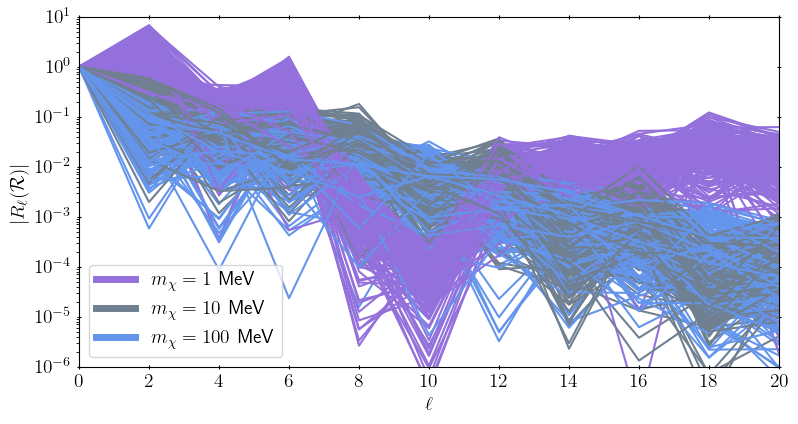

In [38]:
unisize = 3.5
fig = plt.figure(figsize=[2.0*unisize,1*unisize])
ax = fig.add_axes([0,0,1,1], xscale='linear', yscale='log')

for j in range(100):
    i = np.random.randint(0, len(rotationlist))
    rm = (1, 0)
    ax.plot(ells, np.abs(mu_norm[rm][i]), color='mediumpurple')
    rm = (1, 2)
    ax.plot(ells, np.abs(mu_norm[rm][i]), color='mediumpurple')
    rm = (10, 0)
    ax.plot(ells, np.abs(mu_norm[rm][i]), color='slategray')
    rm = (10, 2)
    ax.plot(ells, np.abs(mu_norm[rm][i]), color='slategray')
    rm = (100, 0)
    ax.plot(ells, np.abs(mu_norm[rm][i]), color='cornflowerblue')
    rm = (100, 2)
    ax.plot(ells, np.abs(mu_norm[rm][i]), color='cornflowerblue')

ax.plot(ells, -np.abs(mu_norm[(1,0)][100]), color='mediumpurple', 
        label=r'$m_\chi=1$ MeV', linewidth=5)
ax.plot(ells, -np.abs(mu_norm[(10,0)][100]), color='slategray', 
        label=r'$m_\chi=10$ MeV', linewidth=5)
ax.plot(ells, -np.abs(mu_norm[(100,0)][100]), color='cornflowerblue', 
        label=r'$m_\chi=100$ MeV', linewidth=5)
ax.set_xlim([0,  ellMax])
ax.set_ylim([1e-6, 10])
ax.set_xticks([j for j in range(0, ellMax+1, 2)])
ax.set_ylabel(r'$|R_\ell(\mathcal R)|$', fontsize=14, usetex=True)
ax.set_xlabel(r'$\ell$', fontsize=14, usetex=True)
ax.tick_params(axis='both', labelsize=14, direction='inout',
               right=True, top=True, labelleft=True, labelright=False,
               labelbottom=True, labeltop=False)
ax.legend(fontsize=14)


# plt.savefig('out/partialRate.png', format="png", dpi=300, bbox_inches='tight')
# plt.savefig('out/partialRate.pdf', format="pdf", bbox_inches='tight')

fig.show()

## Azimuthal Slices

In [39]:
rate_rm_phi = {}
thetas = np.array([theta for theta in range(0, 180, 2)])
phis = np.array([phi for phi in range(0, 360, 2)])
for rm in exlist:
    for phi in range(0, 180, 2):
        label = (rm[0], rm[1], phi)
        r_theta = []
        for theta in thetas:
            ix = ix_thetaphi(theta, phi)
            r_theta += [rate_all[rm][ix]]
        r_theta = np.array(r_theta)
        rate_rm_phi[label] = np.array(r_theta)/r_theta.mean()

In [40]:
rate_rm_phi[(10, 2, 80)]

array([0.92145038, 0.94701641, 0.97286827, 0.99869752, 1.0242366 ,
       1.04925705, 1.07355876, 1.09695646, 1.11927088, 1.14032975,
       1.15997897, 1.17809878, 1.19461697, 1.20951171, 1.22280064,
       1.2345193 , 1.24469678, 1.2533384 , 1.26042257, 1.26591335,
       1.26978333, 1.27203705, 1.27272519, 1.27194326, 1.26981577,
       1.26647292, 1.26203004, 1.25657881, 1.25019358, 1.24294956,
       1.23494392, 1.22630963, 1.21721503, 1.20784815, 1.1983917 ,
       1.18899833, 1.17977546, 1.17078455, 1.16205301, 1.15359164,
       1.14540849, 1.13751217, 1.12990337, 1.12255903, 1.11541777,
       1.10837449, 1.1012883 , 1.09400169, 1.08636376, 1.07824862,
       1.06956211, 1.06023581, 1.0502129 , 1.03943424, 1.02783271,
       1.01533979, 1.00190217, 0.98750108, 0.97216549, 0.95597245,
       0.93903385, 0.92147483, 0.90341302, 0.88494753, 0.86616206,
       0.8471402 , 0.82798514, 0.80883377, 0.78985765, 0.77124901,
       0.75319668, 0.73586168, 0.71936232, 0.70377474, 0.68914

In [41]:
thetaphi_size = (np.shape(rotationarray)[0], np.shape(rotationarray)[1])
thetaphiarray = np.array(thetaphilist).reshape(thetaphi_size[0], thetaphi_size[1], 2)
rate_array = {}
for rm in exlist:
    rate_all[rm] = np.array(rate_all[rm])
    rate_array[rm] = rate_all[rm].reshape(thetaphi_size)

# thetaphiarray[0, 1]

In [42]:
m_f_phi_labels = []
for rm in exlist:
    for phi in range(0, 180, 2):
        label = (rm[0], rm[1], phi)
        m_f_phi_labels += [label]

def csv_rmphi_name(label):
    return 'out/R_m{}_f{}_phi{}.csv'.format(label[0],label[1],label[2])

#option: saving results to CSV files:
for label in m_f_phi_labels:
    rate = rate_rm_phi[label]
    # np.savetxt(csv_rmphi_name(label), rate)


/var/folders/9f/0fs4y5917_q6nlh99_p3shbw0000gn/T/ipykernel_42058/3956062709.py:27: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


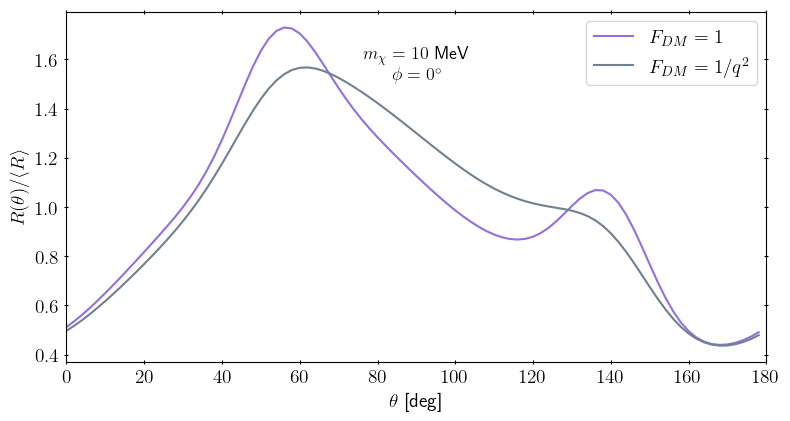

In [43]:
unisize = 3.5
fig = plt.figure(figsize=[2.0*unisize,1*unisize])
ax = fig.add_axes([0,0,1,1], xscale='linear', yscale='linear')

ax.plot(thetas, rate_rm_phi[(10, 0, 0)], color='mediumpurple', label=r'$F_{DM}=1$')
ax.plot(thetas, rate_rm_phi[(10, 2, 0)], color='slategray', label=r'$F_{DM}=1/q^2$')

ax.set_xlim([0,  180])
# ax.set_ylim([1e-10, 2])
# ax.set_xticks([j for j in range(0, ellMax+1, 2)])
ax.set_ylabel(r'$R(\theta)/\langle R \rangle$', fontsize=14, usetex=True)
ax.set_xlabel(r'$\theta$ [deg]', fontsize=14, usetex=True)
ax.tick_params(axis='both', labelsize=14, direction='inout',
               right=True, top=True, labelleft=True, labelright=False,
               labelbottom=True, labeltop=False)

ax.text(0.5, 0.9, r'$m_\chi = 10$ MeV'+'\n' + '$\phi = 0^\circ$', horizontalalignment='center',
        verticalalignment='top', fontsize=13, 
        color='black', backgroundcolor='white',
        transform=ax.transAxes, usetex=True)


ax.legend(fontsize=14)

# plt.savefig('out/boxdiff_R_n_0.pdf', format="pdf", bbox_inches='tight')

fig.show()

### Rates as a function of $\theta$ and $\phi$:

The rotation operator $\mathcal R(\theta, \phi)$ tips the detector (about a rotation axis in the $(x,y)$ plane) until the $z$ axis of the velocity distribution $g_\chi(\vec v)$ is aligned with the unit vector $\hat n = (\theta, \phi)$ of the detector's momentum form factor. 

The color bar of these plots matches $R = \langle R \rangle$ (the angular average) to the center of the color scale. The minimum and maximum values of $R(\theta, \phi)$ are printed above the color bar label. Note that $R(\theta, \phi)$ should be positive: if the minimum of $R$ is negative, this indicates that not enough <gX|nlm> and <fs2|nlm> cofficients have been included in the expansion. (Because the color bar is symmetric about $R = \langle R \rangle$, however, the minimum value on the color bar scale will be negative whenever ${\rm max}(R) > 2 \langle R \rangle$.)

/var/folders/9f/0fs4y5917_q6nlh99_p3shbw0000gn/T/ipykernel_42058/1649931345.py:43: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  fig.colorbar(mappable=clmapZ,
/var/folders/9f/0fs4y5917_q6nlh99_p3shbw0000gn/T/ipykernel_42058/1649931345.py:49: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


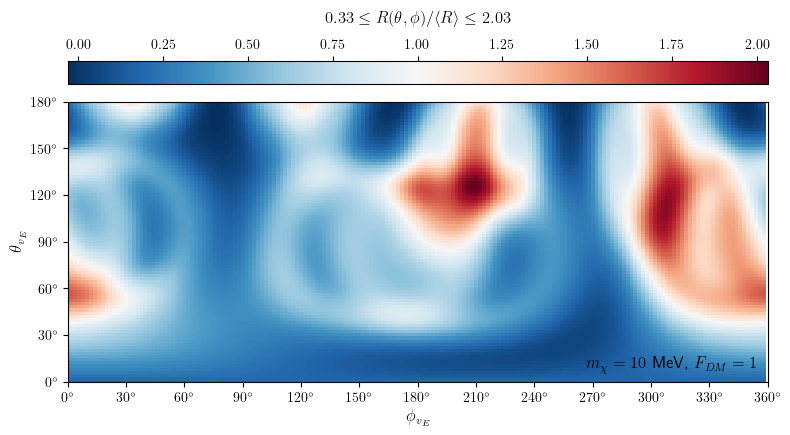

In [44]:
model = (10, 0)

min_r = np.min(rate_array[model]/rate_angavg[model])
max_r = np.max(rate_array[model]/rate_angavg[model])

diff_max = np.max([1 - min_r, max_r - 1])
min_z = 1 - diff_max
max_z = 1 + diff_max

colorZ = 'RdBu_r'
cnormZ = plt.Normalize(vmin=min_z, vmax=max_z)
clmapZ = plt.cm.ScalarMappable(norm=cnormZ, cmap=colorZ)


xlim = [0, 360]
ylim = [0, 180]
tix = [j for j in range(0, 361, 30)]
tiy = [j for j in range(0, 181, 30)]
lblx = [r'${}^\circ$'.format(t) for t in tix]
lbly = [r'${}^\circ$'.format(t) for t in tiy]
fig = plt.figure(figsize=[2.0*unisize,unisize])
ax1 = fig.add_axes([0,0,1,1], xscale='linear', yscale='linear')
ax1.pcolormesh(phis, thetas, rate_array[model]/rate_angavg[model], shading='nearest', cmap=colorZ)
ax1.set_xlim(xlim)
ax1.set_ylim(ylim)
ax1.set_xticks(tix, labels=lblx)
ax1.set_yticks(tiy, labels=lbly)
ax1.set_xlabel(r'$\phi_{v_E}$', fontsize=12, usetex=True)
ax1.set_ylabel(r'$\theta_{v_E}$', fontsize=12, usetex=True)

ax1.text(0.5, 1.27, r'${:.2f} \leq R(\theta, \phi)/\langle R \rangle \leq {:.2f}$'.format(min_r, max_r), 
         horizontalalignment='center',
         verticalalignment='bottom', fontsize=12, 
         color='black', backgroundcolor='white',
         transform=ax1.transAxes, usetex=True)
ax1.text(0.985, 0.03, r'$m_\chi = {}$ MeV, '.format(model[0])+r'$F_{DM} = 1$', 
         horizontalalignment='right',
         verticalalignment='bottom', fontsize=12, 
         color='black', 
         # backgroundcolor='white',
         transform=ax1.transAxes, usetex=True)

fig.colorbar(mappable=clmapZ, 
             orientation='horizontal', location='top', 
             aspect=30)

# plt.savefig('out/rateThetaPhi.png', format="png", dpi=600, bbox_inches='tight')

fig.show()

/var/folders/9f/0fs4y5917_q6nlh99_p3shbw0000gn/T/ipykernel_42058/9667637.py:43: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  fig.colorbar(mappable=clmapZ,
/var/folders/9f/0fs4y5917_q6nlh99_p3shbw0000gn/T/ipykernel_42058/9667637.py:49: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


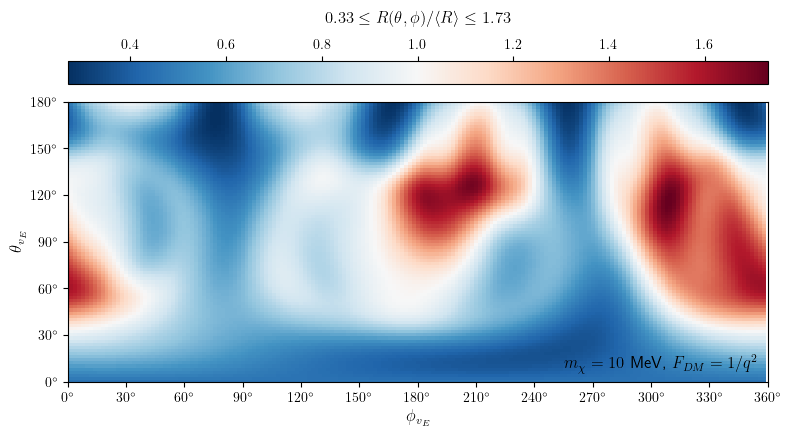

In [46]:
model = (10, 2)

min_r = np.min(rate_array[model]/rate_angavg[model])
max_r = np.max(rate_array[model]/rate_angavg[model])

diff_max = np.max([1 - min_r, max_r - 1])
min_z = 1 - diff_max
max_z = 1 + diff_max

colorZ = 'RdBu_r'
cnormZ = plt.Normalize(vmin=min_z, vmax=max_z)
clmapZ = plt.cm.ScalarMappable(norm=cnormZ, cmap=colorZ)


xlim = [0, 360]
ylim = [0, 180]
tix = [j for j in range(0, 361, 30)]
tiy = [j for j in range(0, 181, 30)]
lblx = [r'${}^\circ$'.format(t) for t in tix]
lbly = [r'${}^\circ$'.format(t) for t in tiy]
fig = plt.figure(figsize=[2.0*unisize,unisize])
ax1 = fig.add_axes([0,0,1,1], xscale='linear', yscale='linear')
ax1.pcolormesh(phis, thetas, rate_array[model]/rate_angavg[model], shading='nearest', cmap=colorZ)
ax1.set_xlim(xlim)
ax1.set_ylim(ylim)
ax1.set_xticks(tix, labels=lblx)
ax1.set_yticks(tiy, labels=lbly)
ax1.set_xlabel(r'$\phi_{v_E}$', fontsize=12, usetex=True)
ax1.set_ylabel(r'$\theta_{v_E}$', fontsize=12, usetex=True)

ax1.text(0.5, 1.27, r'${:.2f} \leq R(\theta, \phi)/\langle R \rangle \leq {:.2f}$'.format(min_r, max_r), 
         horizontalalignment='center',
         verticalalignment='bottom', fontsize=12, 
         color='black', backgroundcolor='white',
         transform=ax1.transAxes, usetex=True)
ax1.text(0.985, 0.03, r'$m_\chi = {}$ MeV, '.format(model[0])+r'$F_{DM} = 1/q^2$', 
         horizontalalignment='right',
         verticalalignment='bottom', fontsize=12, 
         color='black', 
         # backgroundcolor='white',
         transform=ax1.transAxes, usetex=True)

fig.colorbar(mappable=clmapZ, 
             orientation='horizontal', location='top', 
             aspect=30)

# plt.savefig('out/rateThetaPhi.png', format="png", dpi=600, bbox_inches='tight')

fig.show()

The final plots above show $R(\theta, \phi)$ for the $F_{DM} = 1$ and $F_{DM} = 1/q^2$ form factors, with $R$ normalized by the angular average rate $\langle R \rangle$. Note that because $g_\chi(\vec v)$ is not azimuthally symmetric, the values of $R(\theta, \phi)$ at $\theta = 180^\circ$ depend on the value of $\phi$. The trivial rotation at $\theta = 0$, on the other hand, is $\phi$-independent.  